## Final Project Submission

Please fill out:
* Student name: Blake McMeekin
* Student pace: Self Paced
* Scheduled project review date/time: ###
* Instructor name: Claude Fried
* Blog post URL: ###


## Intro

In this project we will analyze movie databases to inform the production of upcoming films for the new Microsoft streaming service. We will be combining databases from IMDB, 'The Movie Database,' and 'The Numbers.'

In [72]:
# First we will import the relevant python packages for data analysis

import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
!pip install pandasql
from pandasql import sqldf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
pysqldf = lambda q: sqldf(q, globals())
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline

In [73]:
# And select the file Paths
the_numbers = 'data/tn.movie_budgets.csv'
im_db = 'data/im.db'
tm_db = 'data/tmdb.movies.csv'

# Gathering and Filtering Data
### First we'll connect to the IMDB SQL database

In [74]:
# Connect to the IMDB SQL database
conn = sqlite3.connect(im_db)

In [75]:
# And make a query
q = """
SELECT *
FROM movie_basics
JOIN movie_ratings
    USING(movie_id)
;"""
imdb = pd.read_sql(q, conn)

In [76]:
print(imdb.shape)
imdb.sort_values('numvotes', ascending=False).head(3)

(73856, 8)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
2387,tt1375666,Inception,Inception,2010,148.00,"Action,Adventure,Sci-Fi",8.80,1841066
2241,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.00,"Action,Thriller",8.40,1387769
280,tt0816692,Interstellar,Interstellar,2014,169.00,"Adventure,Drama,Sci-Fi",8.60,1299334


### We'd also like to get a list of writers and directors by movie into this IMDB database.

In [108]:
# This code block will select sets of writers and writer_ids by movie_id
# First, there's an SQL Query to read from the Database
q = """
SELECT persons.person_id, persons.primary_name, movie_basics.movie_id
FROM movie_basics
JOIN writers
    USING(movie_id)
JOIN persons
    ON(writers.person_id = persons.person_id)
;"""
writers = pd.read_sql(q, conn)

#Then some reformatting to collapse the records into sets
writers = pd.pivot_table(writers, 
                             values=['primary_name', 'person_id'], 
                             index='movie_id', 
                             aggfunc={'primary_name': set, 'person_id':set})
writers.rename(columns = {'primary_name':'writers', 'person_id': 'writer_id'}, inplace=True)

In [109]:
# This code block will select sets of directors and director_ids by movie_id
# First, there's an SQL Query to read from the Database
q = """
SELECT persons.person_id, persons.primary_name, movie_basics.movie_id
FROM movie_basics
JOIN directors
    USING(movie_id)
JOIN persons
    ON(directors.person_id = persons.person_id)
;"""
directors = pd.read_sql(q, conn)

#Then some reformatting to collapse the records into sets
directors = pd.pivot_table(directors, 
                             values=['primary_name', 'person_id'], 
                             index='movie_id', 
                             aggfunc={'primary_name': set, 'person_id':set})
directors.rename(columns = {'primary_name':'directors', 'person_id': 'director_id'}, inplace=True)

In [110]:
# Now the writer and director dataframes are joined with a full outer join
w_d = pd.merge(writers, directors, how='outer', on='movie_id')

# And the combined writer/director dataframe is joined with the initial IMDB dataframe
imdb = pd.merge(imdb, w_d, how='left', on='movie_id')

In [111]:
imdb.sort_values('numvotes', ascending=False).head(3) # Checking the Database

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,writer_id_x,writers_x,director_id_x,directors_x,writer_id_y,writers_y,director_id_y,directors_y
2387,tt1375666,Inception,Inception,2010,148.00,"Action,Adventure,Sci-Fi",8.80,1841066,{nm0634240},{Christopher Nolan},{nm0634240},{Christopher Nolan},{nm0634240},{Christopher Nolan},{nm0634240},{Christopher Nolan}
2241,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.00,"Action,Thriller",8.40,1387769,"{nm0634300, nm0004170, nm0333060, nm0634240}","{David S. Goyer, Christopher Nolan, Bob Kane, ...",{nm0634240},{Christopher Nolan},"{nm0634300, nm0004170, nm0333060, nm0634240}","{David S. Goyer, Christopher Nolan, Bob Kane, ...",{nm0634240},{Christopher Nolan}
280,tt0816692,Interstellar,Interstellar,2014,169.00,"Adventure,Drama,Sci-Fi",8.60,1299334,"{nm0634300, nm0634240}","{Christopher Nolan, Jonathan Nolan}",{nm0634240},{Christopher Nolan},"{nm0634300, nm0634240}","{Christopher Nolan, Jonathan Nolan}",{nm0634240},{Christopher Nolan}


---

### Next we'll connect to 'The Numbers' and 'The Movie Database'

In [112]:
# Connecting to the TN and TMDB Files
tn = pd.read_csv(the_numbers)
tmdb = pd.read_csv(tm_db)
print(f'The Numbers database has shape {tn.shape} and the Movie Database has shape {tmdb.shape}.')

The Numbers database has shape (5782, 6) and the Movie Database has shape (26517, 10).


In [113]:
# Some cleanup
tn[tn.columns[3:]] = tn[tn.columns[3:]].replace('[\$,]', '', regex=True).astype(float) # Convert Prices to Float
tmdb[tmdb.columns[8:]] = tmdb[tmdb.columns[8:]].astype(float) # Convert votes to float
tmdb[tmdb.columns[6:7]] = tmdb[tmdb.columns[6:7]].replace('-', '', regex=True).astype(float) # Convert date to float

#Derive profitability from gross and budget
tn['profit'] = tn['worldwide_gross'] - tn['production_budget'] # Add profit column

### And perform some Joins

In [124]:
# Combine IMDB and The Numbers Databases with an inner join
imdb_tn = pd.merge(tn, imdb, how='inner', left_on='movie', right_on = 'primary_title') # Inner Join on tn and imdb databases
print(f'The inner-join shape of The Numbers and IMDB is {imdb_tn.shape}') # The results of the Inner Join

#And connect The Numbers and The Movie Database with an inner join
tn_tm = pd.merge(tn, tmdb, how='inner', left_on = 'movie', right_on = 'original_title') # Inner Join on tn and tmdb databases
print(f'The inner-join shape of The Numbers and TMDB is {tn_tm.shape}') # The results of the Inner Join

The inner-join shape of The Numbers and IMDB is (2875, 23)
The inner-join shape of The Numbers and TMDB is (2316, 17)


In [125]:
imdb_tn.sort_values('profit', ascending=False).head(3) # Checking the Database

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,movie_id,primary_title,original_title,...,averagerating,numvotes,writer_id_x,writers_x,director_id_x,directors_x,writer_id_y,writers_y,director_id_y,directors_y
0,1,"Dec 18, 2009",Avatar,425000000.00,760507625.00,2776345279.00,2351345279.00,tt1775309,Avatar,Abatâ,...,6.10,43,"{nm4392664, nm2179863}","{Teruo Noguchi, Yûsuke Yamada}",{nm3786927},{Atsushi Wada},"{nm4392664, nm2179863}","{Teruo Noguchi, Yûsuke Yamada}",{nm3786927},{Atsushi Wada}
37,43,"Dec 19, 1997",Titanic,200000000.00,659363944.00,2208208395.00,2008208395.00,tt2495766,Titanic,Titanic,...,6.20,20,{nm5410036},{Kevin Lincoln},"{nm5410036, nm4430776}","{Pete Meads, Kevin Lincoln}",{nm5410036},{Kevin Lincoln},"{nm5410036, nm4430776}","{Pete Meads, Kevin Lincoln}"
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000.00,678815482.00,2048134200.00,1748134200.00,tt4154756,Avengers: Infinity War,Avengers: Infinity War,...,8.50,670926,"{nm1321656, nm2757098, nm1321655, nm1293367, n...","{Christopher Markus, Jim Starlin, Larry Lieber...","{nm0751577, nm0751648}","{Anthony Russo, Joe Russo}","{nm1321656, nm2757098, nm1321655, nm1293367, n...","{Christopher Markus, Jim Starlin, Larry Lieber...","{nm0751577, nm0751648}","{Anthony Russo, Joe Russo}"


We lost a lot of data in that inner join with The Numbers, but we'll use this new dataset to answer some exploratory questions.

# Now we'll ask some questions

## Does profitability correlate with ratings?

In [126]:
profit_rating = imdb_tn['profit'].corr(imdb_tn['averagerating']).round(3)
print(f"""
It appears there's a pearsons correlation of {profit_rating} between profitability and rating. 
That is a fairly weak correlation.
""")


It appears there's a pearsons correlation of 0.162 between profitability and rating. 
That is a fairly weak correlation.



### Barely
Surprisingly, profitability barely correlates with ratings.

---
## Are movies getting more profitable over time?

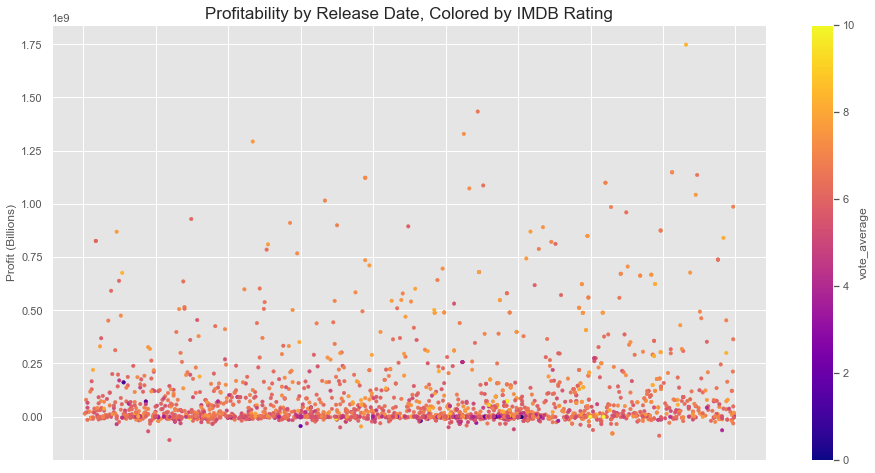

In [127]:
# Create a new dataframe and filter by release date
tn_tm_date = tn_tm
tn_tm_date['release_date_x']= pd.to_datetime(tn_tm_date['release_date_x'])
mask = (tn_tm_date['release_date_x'] > pd.to_datetime('2010/01/01')) & (tn_tm_date['release_date_x'] <= pd.to_datetime('2019/1/1'))

# Make and label scatter plot
plt.style.use('ggplot')
fig1 = tn_tm_date.loc[mask].plot(
    'release_date_x', 'profit', kind='scatter', c='vote_average', colormap = 'plasma', s=12, figsize=(16, 8)
);
fig1.set_title('Profitability by Release Date, Colored by IMDB Rating', fontsize=17);
fig1.set_ylabel('Profit (Billions)');
fig1.set_xlabel('Time, between 2010 and 2019');

In [128]:
tn_tm_date['release_date_x'] = tn_tm_date['release_date_x'].values.astype(int) # Convert datetime to int
tn_tm_date['release_date_x'].corr(tn_tm_date['profit']).round(3) # Here we check the correlation between release date and profit
# From this we see that there is virtually no correlation between date and profitability

0.025

### No

There's a negligible correlation between release date and profitability -- maybe less than inflation.

---

## Does the Worldwide Gross correlate with Profitability?

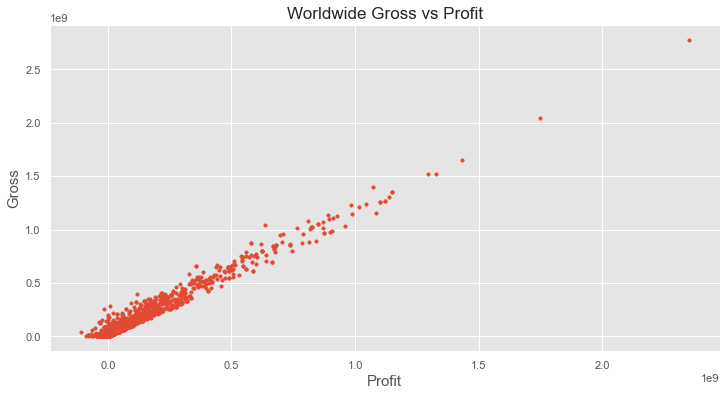

In [129]:
fig2 = tn_tm.plot.scatter('profit', 'worldwide_gross', s=12, figsize=(12, 6), c='#e24a33')
plt.style.use('ggplot')
fig2.set_title('Worldwide Gross vs Profit',fontsize=17);
fig2.set_xlabel('Profit',fontsize=15);
fig2.set_ylabel('Gross',fontsize=15);

In [130]:
tn_tm['profit'].corr(tn_tm['worldwide_gross']).round(3) # Here we check the correlation between worldwide gross and profit
# From this we see that the correlation between profit and gross is very strong

0.986

### Yes
There appears to be a strong correlation between gross and profit. When a movie makes money, it makes money.

---

## What are the ten most/least profitable movies?

We'll use the 'The Numbers' Database (before the inner join).

In [131]:
# The ten most profitable films, by 'The Numbers' Database
tn.sort_values('profit', ascending=False).head(10)[['profit', 'movie', 'release_date']]

,profit,movie,release_date
0,2351345279.00,Avatar,"Dec 18, 2009"
42,2008208395.00,Titanic,"Dec 19, 1997"
6,1748134200.00,Avengers: Infinity War,"Apr 27, 2018"
5,1747311220.00,Star Wars Ep. VII: The Force Awakens,"Dec 18, 2015"
33,1433854864.00,Jurassic World,"Jun 12, 2015"
66,1328722794.00,Furious 7,"Apr 3, 2015"
26,1292935897.00,The Avengers,"May 4, 2012"
260,1216693157.00,Harry Potter and the Deathly Hallows: Part II,"Jul 15, 2011"
41,1148258224.00,Black Panther,"Feb 16, 2018"
112,1135772799.00,Jurassic World: Fallen Kingdom,"Jun 22, 2018"


It's important to note that this data is purely for films and distribution, not for franchises or toys (sorry Star Wars).

In [132]:
# The ten least profitable films, by 'The Numbers' Database
tn.loc[tn['worldwide_gross'] != 0.00].sort_values('profit', ascending=False).tail(10)[['profit', 'movie', 'release_date']]

,profit,movie,release_date
300,-70371823.00,How Do You Know?,"Dec 17, 2010"
435,-73482678.00,Cutthroat Island,"Dec 22, 1995"
607,-73699549.00,A Sound of Thunder,"Sep 2, 2005"
619,-75978328.00,Renegades,"Jan 22, 2019"
477,-79448583.00,The Promise,"Apr 21, 2017"
404,-92905005.00,The Adventures of Pluto Nash,"Aug 16, 2002"
352,-94635231.00,Town & Country,"Apr 27, 2001"
341,-106900000.00,Men in Black: International,"Jun 14, 2019"
193,-110450242.00,Mars Needs Moms,"Mar 11, 2011"
2,-200237650.00,Dark Phoenix,"Jun 7, 2019"


It appears that some of the worldwide gross values are missing from The Numbers database. This list is made of those where the gross value is not missing. Still, some of the numbers in the supplied data may be incorrect - for example, the worldwide gross for MiB:I is $253,890,701 according to a quick google search.

---

## Now some main questions: Which are the best/worst writers and directors?
### First we will look at Writers

In [92]:
# Here we will exploded the database writer column and regroup around those writers.
df = imdb_tn[['release_date', 'movie', 'profit', 'genres', 'runtime_minutes', 'averagerating', 'writers', 'directors']]
df = df.explode('writers')
df = pd.pivot_table(df, 
                             values=['averagerating', 'genres', 'profit', 'movie'], 
                             index='writers', 
                             aggfunc={'movie': set, 'averagerating':'mean', 'genres':set, 'profit':'mean'})
df.rename(columns = {'profit':'averageprofit'}, inplace=True)

# Now we will show writers with credits on more than three films ranked by average profit of those films
writers = df[df['movie'].map(len) >= 3].sort_values('averageprofit', ascending=False)
writers

,averagerating,genres,movie,averageprofit
writers,,,,
Jim Starlin,7.97,"{Action,Adventure,Sci-Fi, Action,Adventure,Com...","{Avengers: Infinity War, Guardians of the Gala...",1140471893.00
Don Heck,7.57,"{Action,Adventure,Sci-Fi}","{Iron Man 2, Avengers: Infinity War, Iron Man 3}",1071560953.67
Gary Scott Thompson,7.07,"{Action,Crime,Thriller}","{The Fate of the Furious, Fast Five, Furious 7}",939577505.00
Joe Simon,7.63,"{Action,Adventure,Sci-Fi}","{Captain America: The First Avenger, Spider-Ma...",865125931.83
J.R.R. Tolkien,7.70,"{Adventure,Family,Fantasy, Adventure,Fantasy}","{The Hobbit: The Battle of the Five Armies, Th...",724316014.67
...,...,...,...,...
Marcia Romano,6.00,"{Drama,Romance,War, Drama}","{Superstar, The Apparition, The History of Love}",-3085704.67
William Shakespeare,7.15,"{Comedy,Romance, Drama,History,War, Drama,Thri...","{Coriolanus, Much Ado About Nothing, Hamlet, R...",-4653309.58
Chad Law,4.93,"{Action,Comedy,Crime, Action,Thriller, Action,...","{The Hit List, Close Range, Drive Hard}",-7000000.00


Here we see the top and bottom five writers with credits on more than three films. Let's look at the histogram.

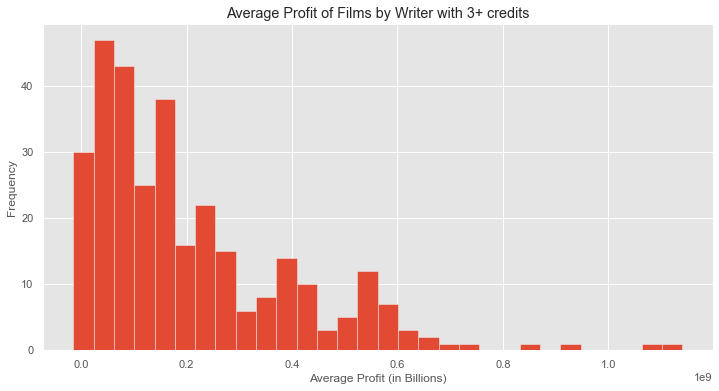

In [93]:
# Now we'll look at the histogram of these writers
fig3 = writers['averageprofit'].plot.hist(bins=30, figsize=(12, 6))
plt.style.use('ggplot')
fig3.set_title('Average Profit of Films by Writer with 3+ credits');
fig3.set_xlabel('Average Profit (in Billions)');

### Some rare writers average much more profitable films.
## Now we will look at directors.

In [94]:
# Here we will exploded the database director column and regroup around those directors.
df = imdb_tn[['release_date', 'movie', 'profit', 'genres', 'runtime_minutes', 'averagerating', 'writers', 'directors']]
df = df.explode('directors')
df = pd.pivot_table(df, 
                             values=['averagerating', 'genres', 'profit', 'movie'], 
                             index='directors', 
                             aggfunc={'movie': set, 'averagerating':'mean', 'genres':set, 'profit':'mean'})
df.rename(columns = {'profit':'averageprofit'}, inplace=True)

# Now we will show directors with credits on more than three films ranked by average profit of those films
directors = df[df['movie'].map(len) >= 3].sort_values('averageprofit', ascending=False)
directors

,averagerating,genres,movie,averageprofit
directors,,,,
Anthony Russo,8.03,"{Action,Adventure,Sci-Fi}","{Avengers: Infinity War, Captain America: Civi...",1060868500.67
Joe Russo,8.03,"{Action,Adventure,Sci-Fi}","{Avengers: Infinity War, Captain America: Civi...",1060868500.67
Pierre Coffin,6.95,"{Animation,Comedy,Family, Adventure,Animation,...","{Despicable Me 2, Despicable Me 3, Minions, De...",854936332.75
Peter Jackson,7.70,"{Adventure,Family,Fantasy, Adventure,Fantasy}","{The Hobbit: The Battle of the Five Armies, Th...",724316014.67
James Wan,7.17,"{Action,Adventure,Fantasy, Action,Crime,Thrill...","{The Conjuring, Aquaman, Furious 7, Insidious}",677997115.25
...,...,...,...,...
Steven Knight,5.97,"{Drama,Mystery,Sci-Fi, Action,Crime,Drama, Drama}","{Redemption, Serenity, Locke}",-5407917.00
Taylor Hackford,5.83,"{Action,Crime,Thriller, Biography,Comedy,Drama...","{Love Ranch, The Comedian, Parker}",-8217252.33
Rob Reiner,6.67,"{Biography,Drama,History, Comedy,Drama,Romance}","{And So It Goes, LBJ, Flipped}",-9094271.00


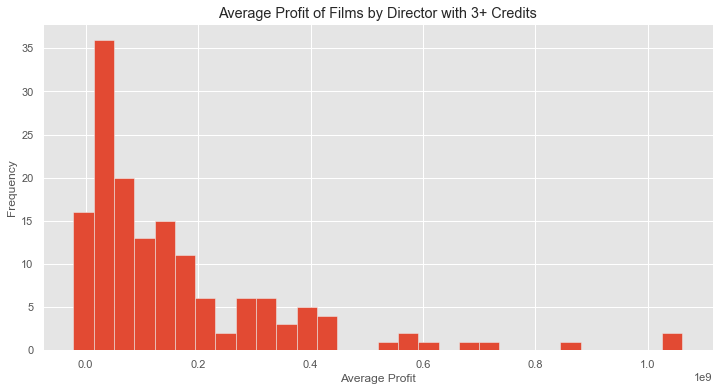

In [95]:
# Now we'll look at the histogram of these directors
fig4 = directors['averageprofit'].plot.hist(bins=30, figsize=(12, 6))
fig4.set_title('Average Profit of Films by Director with 3+ Credits');
fig4.set_xlabel('Average Profit');

### Some rare directors average much more profitable films.
---
## What does the histogram look like for movie profitability?

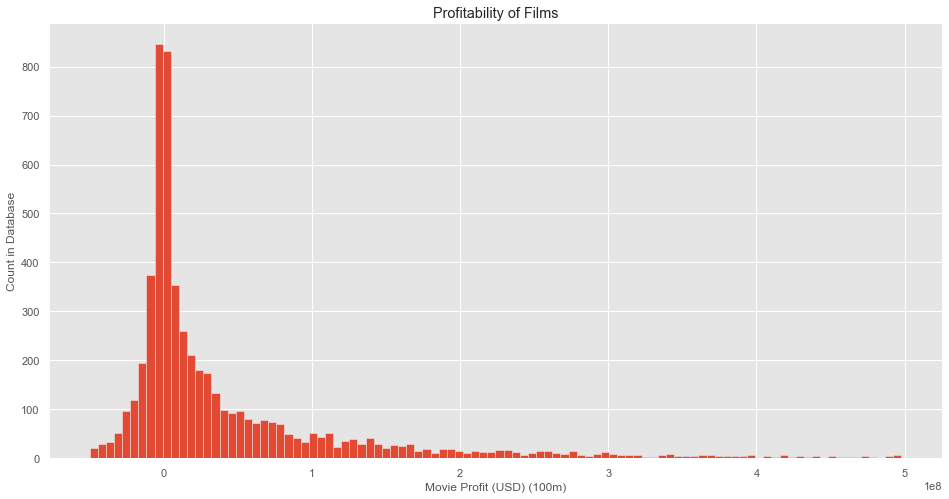

In [96]:
fig5 = tn['profit'].loc[(tn['profit'] <= 500000000)&(tn['profit'] >= -50000000)].plot(kind='hist', figsize=(16, 8), bins=100);
plt.style.use('ggplot')
fig5.set_title('Profitability of Films');
fig5.set_xlabel('Movie Profit (USD) (100m)');
fig5.set_ylabel('Count in Database');

### This distribution correlates a lot with the average profits by director and writer.
---
## Which things correlate most with Profit?

In [97]:
# Here we'll make a new dataframe and delimit the genres by comma to make a list, [genres2]
df = imdb_tn[['release_date', 'movie', 'profit', 'genres', 'runtime_minutes', 'averagerating', 'writers', 'directors']]
genres = df['genres'].str.split(',')
df['genres2'] = genres
df.drop(columns='genres', inplace=True)
df.rename(columns={'genres2':'genres'}, inplace=True)

# Now we'll explode all the groups
df = df.explode('directors')
df = df.explode('writers')
df = df.explode('genres')

C:\Users\8D\AppData\Local\Temp/ipykernel_9008/4132241128.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres2'] = genres
C:\Users\8D\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\8D\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret

In [98]:
# And turn them into categories
df['writers'] = df['writers'].astype('category').cat.codes
df['directors'] = df['directors'].astype('category').cat.codes
df['genres'] = df['genres'].astype('category').cat.codes
df.corr()

,profit,runtime_minutes,averagerating,writers,directors,genres
profit,1.00,0.27,0.34,-0.01,-0.06,-0.16
runtime_minutes,0.27,1.00,0.32,0.04,0.02,-0.03
averagerating,0.34,0.32,1.00,-0.02,-0.05,-0.11
writers,-0.01,0.04,-0.02,1.00,0.22,0.01
directors,-0.06,0.02,-0.05,0.22,1.00,0.01
genres,-0.16,-0.03,-0.11,0.01,0.01,1.00


In [106]:
tn.corr()

,id,production_budget,domestic_gross,worldwide_gross,profit
id,1.00,-0.04,0.01,-0.01,-0.00
production_budget,-0.04,1.00,0.69,0.75,0.61
domestic_gross,0.01,0.69,1.00,0.94,0.93
worldwide_gross,-0.01,0.75,0.94,1.00,0.98
profit,-0.00,0.61,0.93,0.98,1.00


From the first correlation matrix we can see that rating and runtime correlate the most (but not a lot) with profitability, while genre correlates slightly.

From the second (financial) correlation matrix, we can see that the production budget does have a considerable correlation with profit.

---
## Are some Genres more profitable than others?

In [99]:
# Here we'll make a new dataframe and delimit the genres by comma to make a list, [genres2]
df = imdb_tn[['release_date', 'movie', 'profit', 'genres', 'runtime_minutes', 'averagerating', 'writers', 'directors']]
genres = df['genres'].str.split(',')
df['genres2'] = genres
df.drop(columns='genres', inplace=True)
df.rename(columns={'genres2':'genres'}, inplace=True)

# Now we'll explode all the groups
df = df.explode('directors')
df = df.explode('writers')
df = df.explode('genres')

# Make a copy for later use
df_genres = df.copy(deep=True)

# And group around genres
df = pd.pivot_table(df, 
                             values=['averagerating', 'profit'], 
                             index='genres', 
                             aggfunc={'averagerating':'mean', 'profit':'mean'})
df.rename(columns={'profit':'averageprofit'}, inplace=True)
df.sort_values('averageprofit', ascending=False, inplace=True)

C:\Users\8D\AppData\Local\Temp/ipykernel_9008/3397271750.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres2'] = genres
C:\Users\8D\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\8D\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret

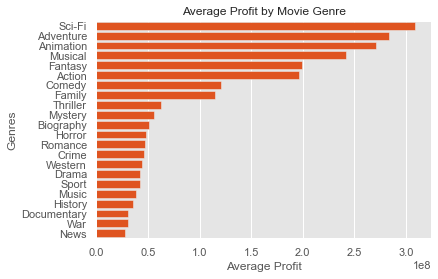

In [100]:
# Make a bar plot showing profit by genre
fig7 = sns.barplot(x='averageprofit',
                   y=df.index,
                   data=df,
                   orient='h', 
                   color='orangered');

sns.set(rc = {'figure.figsize': (16,12)})
fig7.set_title('Average Profit by Movie Genre');
fig7.set_xlabel('Average Profit');
fig7.set_ylabel('Genres');


---
## What is the popularity of genres across time?


In [133]:
# Duplicate Dataframe to perform some transformations
df_genre = df_genres
df_genre = df_genre.dropna().reset_index()

# Change to datetime and filter by date, filter to only certain genres
df_genre['release_date']= pd.to_datetime(df_genre['release_date'])
mask = (df_genre['release_date'] > pd.to_datetime('2010/01/01')) & (df_genre['release_date'] <= pd.to_datetime('2021/12/31'))
df_genre = df_genre.loc[df_genre['genres'].isin([
    'Sci-Fi', 'Adventure', 'Animation', 'Fantasy', 'Action', 'Comedy', 'Family', 'Thriller'
])]

# Group By genres and Release Date
df_genre = df_genre.loc[mask].groupby([pd.Grouper(key='release_date', axis=0, freq='M'), 'genres']).sum()

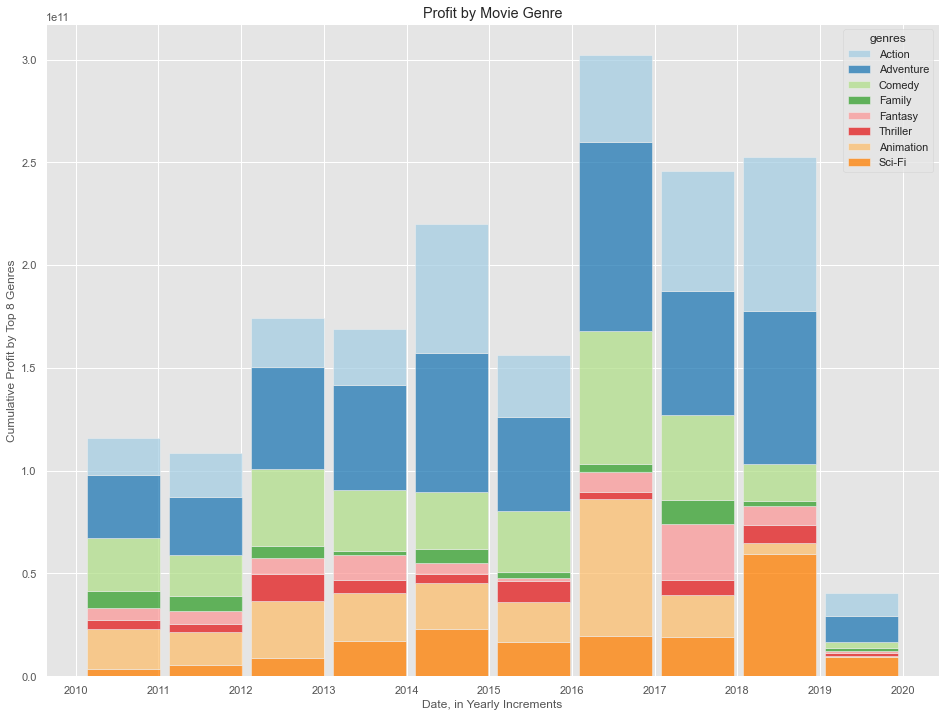

In [134]:
# Make a stacked bar plot showing profit by genre
sns.color_palette("flare", as_cmap=True)

fig8 = sns.histplot(
    df_genre.reset_index(),
    x='release_date',
    weights='profit',
    hue='genres',
    multiple='stack',
    bins=10,
    palette = 'Paired',
    shrink=.9
)

fig8.set_title('Profit by Movie Genre');
fig8.set_xlabel('Date, in Yearly Increments');
fig8.set_ylabel('Cumulative Profit by Top 8 Genres');

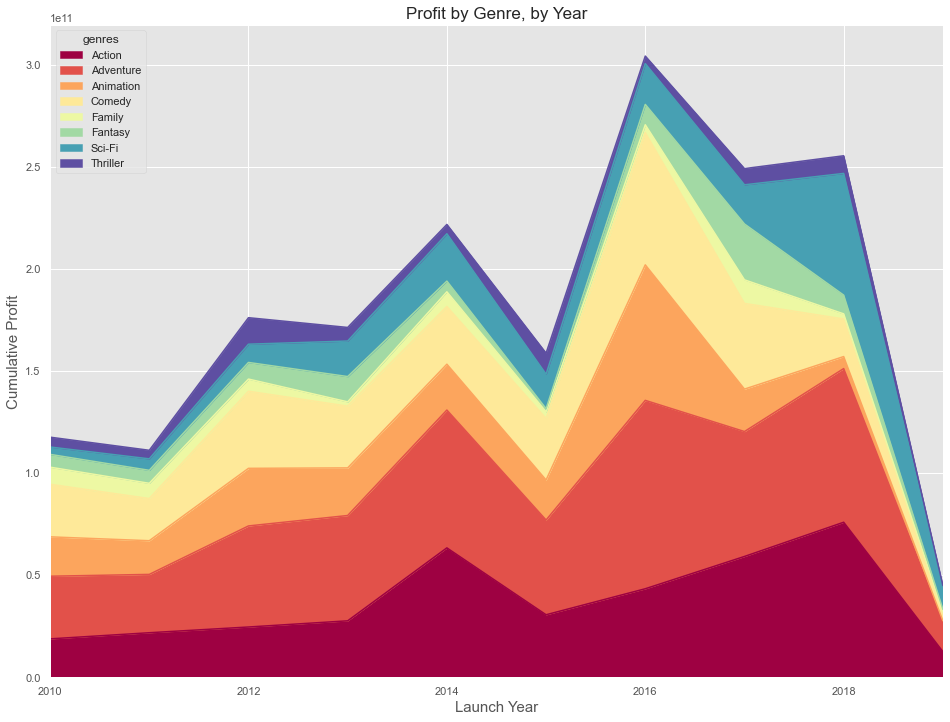

In [136]:
# This code block will create a stacked area chart (which only works with positive values)
df_genre = df_genres.loc[df_genres['profit'] >= 0]
df_genre = df_genre.dropna().reset_index()

# Data processing module
df_genre['release_date']= pd.to_datetime(df_genre['release_date'])
mask = (df_genre['release_date'] > pd.to_datetime('2010/01/01')) & (df_genre['release_date'] <= pd.to_datetime('2021/12/31'))
df_genre = df_genre.loc[df_genre['genres'].isin([
    'Sci-Fi', 'Adventure', 'Animation', 'Fantasy', 'Action', 'Comedy', 'Family', 'Thriller'
])]
df_genre = df_genre.loc[mask].groupby([pd.Grouper(key='release_date', axis=0, freq='Y'), 'genres']).sum()

df_genre = df_genre.unstack()
df_genre = df_genre.fillna(0)

# Create the Chart
plt.style.use('tableau-colorblind10')
df_genre['profit'].plot.area(cmap='Spectral')
plt.xlabel('Launch Year', fontsize=15)
plt.ylabel('Cumulative Profit', fontsize=15)
plt.title('Profit by Genre, by Year',fontsize=17);

# Thanks for reading!